# 프로젝트 착수 전 환경 설정 관련 코드

In [ ]:
import os
# 필요 라이브러리 및 업데이트 진행 (세션 재시작되므로, 다음 코드 블럭부터 다시 실행)

# !pip install datasets
# !pip install accelerate -U

# os.kill(os.getpid(), 9)

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 한국어 데이터셋 기반 KLUE 모델로 NSMC 태스크 수행

## NSMC 데이터 분석 및 Huggingface dataset 구성

### 데이터 확인

In [ ]:
import pandas as pd

# 파일 읽기
file_path = '/content/drive/MyDrive/Data/NSMC/ratings.txt'
df = pd.read_csv(file_path, delimiter='\t')  # 탭으로 구분된 파일 읽기

df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
df.drop(columns="id", inplace=True)
df.head()

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


 ### 전처리1: 결측치 및 중복 데이터 제거

In [ ]:
def check_missing_values(data, name):
    # 결측 데이터의 존재 여부를 확인
    if data.isnull().any().any():
        missing_info = data.isnull().sum()
        print(f"{name}: 결측치가 있습니다. 각 열의 결측치 수는 다음과 같습니다:\n{missing_info}")
        # 결측치가 있는 행을 출력
        missing_rows = data[data.isnull().any(axis=1)]
        print(f"{name}: 결측치가 있는 행은 다음과 같습니다:\n{missing_rows}")
    else:
        print(f"{name}: 결측치가 없습니다. 데이터 크기는 {data.shape}입니다")

check_missing_values(df, 'NSMC_data')

NSMC_data: 결측치가 있습니다. 각 열의 결측치 수는 다음과 같습니다:
document    8
label       0
dtype: int64
NSMC_data: 결측치가 있는 행은 다음과 같습니다:
       document  label
46471       NaN      1
60735       NaN      1
77665       NaN      1
84098       NaN      1
127017      NaN      0
172375      NaN      0
173526      NaN      0
197279      NaN      0


In [ ]:
# 결측치 확인 후 제거
def remove_missing_values(data, name):
    # 결측치 제거 전 데이터 크기
    original_size = data.shape
    print(f"{name}: 결측치 제거 전 데이터 크기는 {original_size}입니다.")

    # 결측치가 있는 행을 제거
    data_cleaned = data.dropna()

    # 결측치 제거 후 데이터 크기
    cleaned_size = data_cleaned.shape
    print(f"{name}: 결측치 제거 후 데이터 크기는 {cleaned_size}입니다.")

    # 제거된 행의 수
    rows_removed = original_size[0] - cleaned_size[0]
    print(f"{name}: 제거된 행의 수는 {rows_removed}개입니다.")

    return data_cleaned

# train_data에서 결측치가 있는 행을 제거하고 결과를 출력
df = remove_missing_values(df, 'NSMC_data')

NSMC_data: 결측치 제거 전 데이터 크기는 (200000, 2)입니다.
NSMC_data: 결측치 제거 후 데이터 크기는 (199992, 2)입니다.
NSMC_data: 제거된 행의 수는 8개입니다.


In [ ]:
# 중복 데이터 확인
def check_duplicates(data, name):
    if data.duplicated().any():
        print(f"{name}: 중복 데이터가 있습니다. 데이터 크기는 {data.shape}입니다")
    else:
        print(f"{name}: 중복 데이터가 없습니다. 데이터 크기는 {data.shape}입니다")

check_duplicates(df, 'NSMC_data')

NSMC_data: 중복 데이터가 있습니다. 데이터 크기는 (199992, 2)입니다


### 전처리2: 데이터 정규화(특수문자를 포함한 데이터 삭제)

In [ ]:
# 전체 토큰 수와 예외 데이터를 줄이기 위해 정의되지 않은 문자가 포함된 행을 제외
import pandas as pd
import re

# 정규화 대상 문자만 포함하는지 확인하는 함수
def contains_only_allowed_chars(text):
    return re.fullmatch("[가-힣a-zA-Z0-9^(♥)!,. ]*", str(text)) is not None

# 조건에 맞는 행만 선택하여 새로운 데이터프레임 생성
filtered_df = df[df['document'].apply(contains_only_allowed_chars)]

# 새로운 데이터프레임의 크기 확인
print(filtered_df.shape)


(140125, 2)


### 허깅페이스 데이터셋으로 변환

In [ ]:
from datasets import Dataset
# pandas 데이터프레임을 Hugging Face 데이터셋으로 변환
hf_dataset = Dataset.from_pandas(filtered_df)

# 데이터를 train, validation, test로 각각 70%, 15%, 15%로 분할
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size

train_dataset = df[:train_size]
val_dataset = df[train_size:train_size + val_size]
test_dataset = df[train_size + val_size:]

# DataFrame 데이터를 dict 내부에 list로 변경
train_dataset = train_dataset.to_dict('list')
val_dataset = val_dataset.to_dict('list')
test_dataset = test_dataset.to_dict('list')

# Hugging Face dataset으로 변환
tf_train_dataset = Dataset.from_dict(train_dataset)
tf_val_dataset = Dataset.from_dict(val_dataset)
tf_test_dataset = Dataset.from_dict(test_dataset)

In [ ]:
# 훈련 데이터셋 확인
print(hf_dataset)

Dataset({
    features: ['document', 'label', '__index_level_0__'],
    num_rows: 140125
})


In [ ]:
from datasets import Dataset, DatasetDict

# pandas 데이터프레임을 Hugging Face 데이터셋으로 변환
hf_dataset = Dataset.from_pandas(filtered_df)

# 데이터셋을 훈련, 검증, 테스트 세트로 분할 (비율: 70%, 15%, 15%)
train_testvalid = hf_dataset.train_test_split(test_size=0.3)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

# 분할된 데이터셋을 DatasetDict 형태로 조합
hf_dataset_dict = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

# 결과 확인
print(hf_dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['document', 'label', '__index_level_0__'],
        num_rows: 98087
    })
    validation: Dataset({
        features: ['document', 'label', '__index_level_0__'],
        num_rows: 21019
    })
    test: Dataset({
        features: ['document', 'label', '__index_level_0__'],
        num_rows: 21019
    })
})


In [ ]:
# 훈련 데이터셋 확인
for i in range(5):
    for column in hf_dataset_dict['train'].column_names:
        print(column, ":", hf_dataset_dict['train'][column][i])
    print('\n')

document : 너무잼있어요 로맨스 스릴러 거기다 반전에반전을..
label : 1
__index_level_0__ : 60261


document : 액션이 무엇인지 잘 보여주는 영화
label : 1
__index_level_0__ : 662


document : 이런 유치하고 뻔하디 뻔한 감성을 봤나...
label : 0
__index_level_0__ : 199090


document : 역시 여름엔 그랑블루.
label : 1
__index_level_0__ : 74865


document : 일본작가와 일본 스텝, 일본 제작진들이 한국의 능력있는 김태균 감독을 매장시키네
label : 0
__index_level_0__ : 151123




## 토크나이저, 모델 선언

모델과 데이터에 관한 정보는 링크를 참조해주세요.

- [KLUE/Bert-base](https://huggingface.co/klue/bert-base)

In [ ]:
# klue/bert-base model 및 tokenizer 불러오기

from transformers import BertForSequenceClassification, AutoTokenizer

# 이진 감성분류 문제에도 SequenceClassification 사용가능
model = BertForSequenceClassification.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# 훈련데이터로부터 샘플을 불러와 토크나이저 적용

# 변환 함수 정의
def transform(data):
    return tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )

# 먼저 5개의 샘플을 선택
selected_samples = hf_dataset_dict['train'].select(range(5))

# 선택된 샘플에 대해 변환 수행
transformed_samples = selected_samples.map(transform)

# 결과 출력
for sample in transformed_samples:
    print(sample)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

{'document': '너무잼있어요 로맨스 스릴러 거기다 반전에반전을..', 'label': 1, '__index_level_0__': 60261, 'input_ids': [2, 3760, 3468, 2689, 10283, 12752, 19445, 4370, 2062, 8984, 2170, 2536, 2165, 2069, 18, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# 매핑(mapping)을 이용한 다중 처리 기법
hf_dataset = hf_dataset_dict.map(transform, batched=True)

Map:   0%|          | 0/98087 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

In [ ]:
# 훈련, 검증, 테스트 데이터셋 분할
hf_train_dataset = hf_dataset['train']
hf_val_dataset = hf_dataset['validation']
hf_test_dataset = hf_dataset['test']

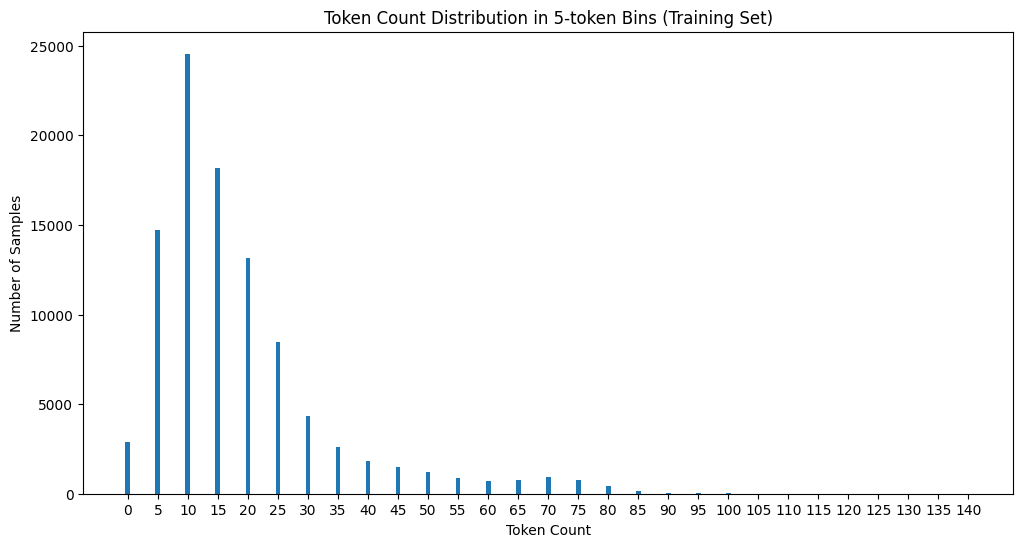

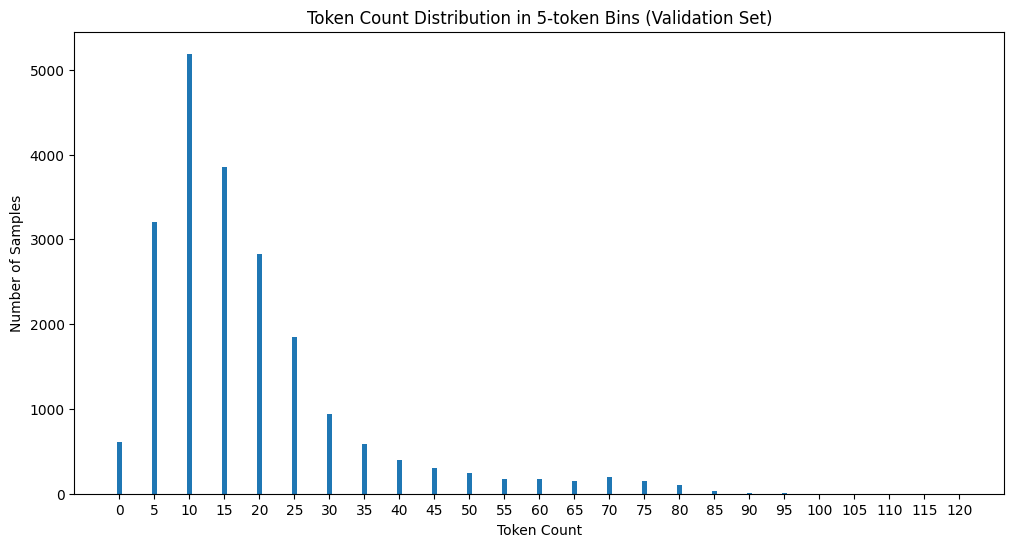

Training Set 95% 토큰 최대 수: 54
Validation Set 95% 토큰 최대 수: 53


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def count_tokens_and_visualize(dataset, dataset_name):
    # 0이 아닌 토큰의 개수 계산
    token_counts = [len([i for i in input_ids if i != 0]) for input_ids in dataset['input_ids']]

    # 5개 단위로 묶기
    token_counts_binned = [(count // 5) * 5 for count in token_counts]

    # 개수 세기
    count_dict = Counter(token_counts_binned)

    # 막대 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.bar(count_dict.keys(), count_dict.values())
    plt.title(f'Token Count Distribution in 5-token Bins ({dataset_name})')
    plt.xlabel('Token Count')
    plt.ylabel('Number of Samples')
    plt.xticks(range(0, max(token_counts_binned) + 5, 5))
    plt.show()

    # 퍼센트에 해당하는 임계값 계산
    percentage = 95
    threshold = np.percentile(token_counts, percentage)

    return int(threshold)

# 훈련 데이터셋에 대한 시각화 수행 및 95% 토큰 최대 수 찾기
train_threshold = count_tokens_and_visualize(hf_train_dataset, "Training Set")

# 검증 데이터셋에 대한 시각화 수행 및 95% 토큰 최대 수 찾기
val_threshold = count_tokens_and_visualize(hf_val_dataset, "Validation Set")

print(f"Training Set 95% 토큰 최대 수: {train_threshold}")
print(f"Validation Set 95% 토큰 최대 수: {val_threshold}")


In [ ]:
# 훈련 시간이 너무 길어지지 않도록, 최대 길이를 60으로 조정하여 다시 진행

# 변환 함수 정의
def transform_with_max_length(data):
    return tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        max_length=60,
        return_token_type_ids=False,
    )

# 매핑(mapping)을 이용한 다중 처리 기법
hf_dataset_max_with_length = hf_dataset_dict.map(transform_with_max_length, batched=True)

# 훈련, 검증, 테스트 데이터셋 분할
hf_train_dataset = hf_dataset_max_with_length['train']
hf_val_dataset = hf_dataset_max_with_length['validation']
hf_test_dataset = hf_dataset_max_with_length['test']

Map:   0%|          | 0/98087 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

## 학습 진행

In [ ]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

# TrainingArguments 설정
training_arguments = TrainingArguments(
    output_dir="./results",         # 결과를 저장할 디렉토리
    num_train_epochs=3,             # 학습 에포크 수
    per_device_train_batch_size=16, # 각 디바이스당 배치 크기
    per_device_eval_batch_size=64,  # 평가시 배치 크기
    warmup_steps=500,               # 워밍업을 위한 스텝 수
    weight_decay=0.01,              # 가중치 감쇠
    logging_dir="./logs",           # 로그를 저장할 디렉토리
    save_steps=10000
)


In [ ]:
from datasets import load_metric

metric = load_metric('glue', 'mrpc')

# 태스크별 출력형식을 고려한 메트릭 계산 함수
def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

<ipython-input-23-8d3e1056a6c9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'mrpc')


In [ ]:
# 학습 진행

trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.431200
1000,0.366100
1500,0.338400
2000,0.321400
2500,0.307600
3000,0.305400
3500,0.293400
4000,0.297800
4500,0.291000
5000,0.287800


TrainOutput(global_step=18393, training_loss=0.21886324069760904, metrics={'train_runtime': 3952.0673, 'train_samples_per_second': 74.457, 'train_steps_per_second': 4.654, 'total_flos': 9073045577494800.0, 'train_loss': 0.21886324069760904, 'epoch': 3.0})

In [ ]:
# 테스트 데이터로 평가
trainer.evaluate(hf_test_dataset)

{'eval_loss': 0.423963338136673,
 'eval_accuracy': 0.8950949141253152,
 'eval_f1': 0.8966680725432307,
 'eval_runtime': 70.896,
 'eval_samples_per_second': 296.476,
 'eval_steps_per_second': 4.641,
 'epoch': 3.0}

## 성능 개선을 통해 정확도(accuracy) 높이기
- 목표: 정확도 90%

### 버케팅과 다이나믹 패딩 적용하여 성능 비교평가

- 아래 링크를 바탕으로 bucketing과 dynamic padding 적용하여 model을 학습

[Data Collator]

[`Trainer.TrainingArguments`의 `group_by_length`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

In [ ]:
from transformers import DataCollatorWithPadding

# 토크나이징 함수 정의 (패딩 제외)
def tokenize_function(examples):
    return tokenizer(examples["document"], truncation=True, padding=False)

# 데이터셋에 토크나이징 함수 적용
tokenized_datasets = hf_dataset_dict.map(tokenize_function, batched=True)

# 데이터셋 형식을 PyTorch 텐서로 설정
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 데이터셋 분할
hf_train_dataset = tokenized_datasets["train"]
hf_val_dataset = tokenized_datasets["validation"]
hf_test_dataset = tokenized_datasets["test"]

# 데이터 콜레이터 초기화
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

Map:   0%|          | 0/98087 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

### TrainingArguments 수정

#### 수정된 인자
- num_train_epochs: 모델이 데이터에 충분히 학습되지 않아 underfitting이 발생하는 경우, 학습 에포크 수를 늘리는 것이 도움이 될 수 있습니다. 더 많은 에포크는 모델이 학습 데이터를 더 잘 이해하고, 더 정확한 예측을 할 수 있게 도와줍니다.

- learning_rate: 학습률은 모델이 얼마나 빠르게 수렴하는지를 결정합니다. 너무 높은 학습률은 수렴을 놓칠 수 있고, 너무 낮은 학습률은 학습 속도를 느리게 할 수 있습니다. 적절한 학습률을 찾는 것은 중요합니다.

- weight_decay: L2 정규화를 통해 모델의 과적합(overfitting)을 방지할 수 있습니다. 이는 모델이 학습 데이터에 너무 맞춰져 새로운 데이터에 대한 일반화 능력이 떨어지는 것을 방지합니다.

- warmup_steps: 학습 초기에 학습률을 점진적으로 증가시키는 것은 모델이 안정적으로 수렴하도록 도와줍니다. 이는 특히 큰 학습률을 사용할 때 유용합니다.

- label_smoothing_factor: 레이블 스무딩은 모델이 너무 확신을 가지고 예측하는 것을 방지하여 과적합을 줄일 수 있습니다. 이는 모델이 더 견고하게 일반화하는 데 도움이 됩니다.

In [ ]:
# 메트릭 오류 수정

metric = load_metric('accuracy')

# 태스크별 출력형식을 고려한 메트릭 계산 함수
def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [ ]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience: int):
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = np.inf
        self.patience_counter = 0

    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        # 현재 검증 손실을 체크
        current_loss = state.log_history[-1]["eval_loss"]

        # 손실이 이전 최고값보다 낮으면, 최고값 업데이트 및 카운터 초기화
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.patience_counter = 0
        # 손실이 개선되지 않으면 카운터 증가
        else:
            self.patience_counter += 1

        # 카운터가 인내심 한계에 도달하면 훈련 중단
        if self.patience_counter >= self.early_stopping_patience:
            control.should_training_stop = True

# TrainingArguments 설정
training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_dynamic_padding_mod",
    save_steps=2000,
    save_strategy="steps",
    evaluation_strategy="steps",
    eval_steps=500,
    label_smoothing_factor=0.1,  # 레이블 스무딩 적용
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# EarlyStoppingCallback 인스턴스 생성
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5000)

# 모델 다시 로드
model_retry_re = BertForSequenceClassification.from_pretrained("klue/bert-base")

# Trainer 설정
trainer = Trainer(
    model=model_retry_re,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # 콜백 추가
)

trainer.train()

# 테스트 데이터로 평가
trainer.evaluate(hf_test_dataset)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
500,0.492300,0.430908,0.857367
1000,0.413500,0.398228,0.875494
1500,0.401600,0.381313,0.884866
2000,0.398700,0.379358,0.883962
2500,0.395800,0.369752,0.892002
3000,0.384800,0.379172,0.889671
3500,0.387800,0.365582,0.895809
4000,0.375500,0.370558,0.897283
4500,0.376000,0.362167,0.900138
5000,0.376200,0.360171,0.898616


{'eval_loss': 0.3563438951969147,
 'eval_accuracy': 0.9020410105142966,
 'eval_runtime': 88.2803,
 'eval_samples_per_second': 238.094,
 'eval_steps_per_second': 3.727,
 'epoch': 3.0}

In [ ]:
# 테스트 데이터로 평가
trainer.evaluate(hf_test_dataset)

{'eval_loss': 0.3563438951969147,
 'eval_accuracy': 0.9020410105142966,
 'eval_runtime': 88.4381,
 'eval_samples_per_second': 237.669,
 'eval_steps_per_second': 3.72,
 'epoch': 3.0}

# 회고
허깅페이스라는 새로운 프레임워크로 작업을 진행하다보니, 결과를 보고 나서 '아차, 이거 고쳐야 했는데' 하는 부분이 많았다.

예를 들어서 훈련 진행 중이 'loss'값만 보여주는데 이게 훈련 손실함수값인지 검증 손실함수 값인지 알수가 없었다.

평가 기준(metric)이나 함수 정의하는 데 있어서도 조금 더 엄밀하게 따져보지 못했고, 그것들이 훈련에 어떤 영향을 미치는지 정확히 검증할 수 없었다.

사후적으로 새로 훈련을 진행하면서 검증값이 제일 낮은 모델을 사용하도록 해야 하는데, 과적합이 일어난 모델을 사용하도록 지정이 되는 것으로 보인다.

새로운 프레임워크를 사용할때, 기존에 사용했던(나의 경우에는 텐서플로) 작업진행 루틴에서 어떤 부분들을 중요한 체크포인트로 삼을지를 미리 정하고, 그에 맞게 진행과정을 시각화할 수 있도록 코딩을 해야겠다.